<a href="https://colab.research.google.com/github/kstrickland680/DepressionSentimentalAnalysis/blob/main/DepressionTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depression Sentiment Analysis

## Overview

This project analyzes twitter data that has been labeled according to whether it was written by a clinically depressed individual or not.  The project explores frequently used words, conducts a topic analysis, performs sentiment analysis, and creates a model to predict whether an individual is likely to be depressed based on their social media precense on Twitter. 

## Business Problem  

A nonprofit agency focused on mental health and depression wants a way to analyze Twitter data to assess for depression in individuals. Doing so can bolster prevention efforts to help individuals with depression.  

According to the Anxiety and Depression Association of America, Major Depressive Disorder (MDD) is the leading cause of disability for adults in the US aged 15-44. Over 16.1 million adults in America are affected by it each year.  Only 61% of adults with MDD receive treatment.  The US Department of Health & Human Services estimates that 60% of individuals who commit suicide had a mood disorder, such as MDD or bipolar.  

In [ ]:
!pip install vaderSentiment

In [ ]:
import pandas as pd

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import string

import re

from nltk.stem import WordNetLemmatizer

import tensorflow as tf

from gensim.models import Word2Vec

from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image

from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score

import requests
import bs4
from bs4 import BeautifulSoup
from requests_oauthlib import OAuth1
import tweepy

from sklearn.utils import class_weight
from random import shuffle



In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#path = "drive/My Drive/DepressionTweets"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Understanding

The dataset consists of an index number, the tweet, and a classification as depressed/not depressed.  22.4% of the dataset is classified as written by a clinically depressed individual. 


In [ ]:
df = pd.read_csv('/content/drive/My Drive/DepressionTweets/DepressionSentimentalAnalysis/data/sentiment_tweets3.csv')


In [ ]:
df.head(20)

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,624,so sleepy. good times tonight though,0
6,701,"@SilkCharm re: #nbn as someone already said, d...",0
7,808,23 or 24ï¿½C possible today. Nice,0
8,1193,nite twitterville workout in the am -ciao,0
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0


In [ ]:
df['label (depression result)'].value_counts(normalize = True)

0    0.775645
1    0.224355
Name: label (depression result), dtype: float64

In [ ]:
df.shape

(10314, 3)

In [ ]:
df.drop_duplicates(subset=['message to examine'])
df.shape

(10314, 3)

In [ ]:
df.isna().any()

Index                        False
message to examine           False
label (depression result)    False
dtype: bool

## Data Preparation 

I create functions to help clean the text, including removing punctuation, URLs, stemming the text, and tokenizing it. 

In [ ]:
def nopunct(tweet):
    """ Removes punctuation."""
    
    new_words = [word for word in tweet if word.isalnum()]
    return new_words

In [ ]:
def stemming(tweet):
  """ Returns the tweet with stemmed words using Porter Stemmer. """
  
  ps = PorterStemmer()
  stemmed = [ps.stem(word) for word in tweet]
  return stemmed



In [ ]:
def clean_and_tokenize(data, message):
  """ Prepares the data for the tokenizer and tokenizes it.

  Removes URLs, numbers, hashtags, and punctuation.  Uses tweet tokenizer and porter stemmer. 

  Parameters: 
  dataframe, name of column with strings that need tokenization

  Returns: 
  Dataframe with columns added.  ['tokenized'] contains the the tokenized version. 
  ['toknizedandstemmed'] contains the version that's tokenized, stemmed, and has no punctuation. """


  #takes in a data frame and original tweet

  #remove URLS:
  data['tokenized'] = [' '.join(re.sub("http://\S+", " ", tweet).split()) for tweet in data[message]]
  data['tokenized'] = [' '.join(re.sub("myspace.com\S+", " ", tweet).split()) for tweet in data['tokenized']]
  data['tokenized'] = [' '.join(re.sub("https://\S+", " ", tweet).split()) for tweet in data['tokenized']]

  #remove numbers
  data['tokenized'] = [' '.join(re.sub(r'\d+', '', tweet).split()) for tweet in data['tokenized']]

  #remove hashtag
  data['tokenized'] = [' '.join(re.sub('#', "", tweet).split()) for tweet in data['tokenized']]

  #tweet tokenizer (lower clase, get rid of handles, reduce repeated letters)
  tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles = True, reduce_len=True)
  data['tokenized'] = [tweet_tokenizer.tokenize(entry) for entry in data['tokenized']]

  #stem the words
  data['tokenizedandstemmed'] = [stemming(tweet) for tweet in data['tokenized']]

  #remove punctuation
  data['tokenizedandstemmed'] = [nopunct(tweet) for tweet in data['tokenizedandstemmed']]

  return data


In [ ]:
def sentiment_prep(data, message):
  """ Prepares data for VADER sentiment analysis. 

  Modifies the dataframe to add a column with no URLs, numbers, hashtags, mentions, punctuation, and special characters. 

  Inputs:
  Dataframe, name of column with tweet to be prepared. 

  Returns:
  Modified dataframe. ['tokenized'] column removes URLs, numbers, hashag, mentions, and special characters. 
  ['tokenizedwithpunct] column removes URLs, numbers, hashtags, and mentions. """


  #takes in dataframe and name of column with the tweet
  #prepares data for sentiment analysis.  It keeps punctuation, doesn't stem the words, and doesn't tokenize i


  #remove URLS:
  data['tokenized'] = [' '.join(re.sub("http://\S+", " ", tweet).split()) for tweet in data[message]]
  data['tokenized'] = [' '.join(re.sub("https://\S+", " ", tweet).split()) for tweet in data['tokenized']]
  data['tokenized'] = [' '.join(re.sub("myspace.com\S+", " ", tweet).split()) for tweet in data['tokenized']]

  #remove numbers
  data['tokenized'] = [' '.join(re.sub(r'\d+', '', tweet).split()) for tweet in data['tokenized']]

  #remove hashtag
  data['tokenized'] = [' '.join(re.sub('#', "", tweet).split()) for tweet in data['tokenized']]

  #remove mentions: 
  data['tokenized']=data['tokenized'].apply(lambda x :[t for t in x.split() if not t.startswith('@')]).apply(lambda x: ' '.join(x))

  data['tokenizedwithpunct'] = data['tokenized']
  #remove special characters and numbers
  data['tokenized'] = data['tokenized'].replace(r'[^A-Za-z]+', " ", regex=True)
  return data




## Depression Data

I create a dataframe of only the tweets from depressed indivduals to explore frequently used words and topics. I create a word cloud, which features words including depression, worthless, anti, anxiety, and functioning. 

In [ ]:
df = clean_and_tokenize(df, 'message to examine')
df.head()

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed
0,106,just had a real good moment. i missssssssss hi...,0,"[just, had, a, real, good, moment, ., i, misss...","[just, had, a, real, good, moment, i, misss, h..."
1,217,is reading manga http://plurk.com/p/mzp1e,0,"[is, reading, manga]","[is, read, manga]"
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,[-],[]
3,288,@lapcat Need to send 'em to my accountant tomo...,0,"[need, to, send, ', em, to, my, accountant, to...","[need, to, send, em, to, my, account, tomorrow..."
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,"[add, me, on, myspace, !, !, !]","[add, me, on, myspac]"


<function matplotlib.pyplot.show>

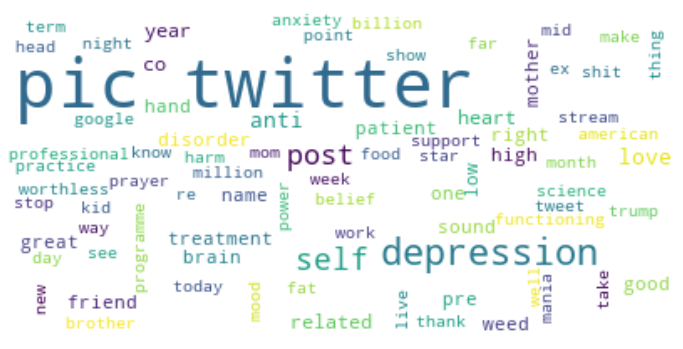

In [ ]:

stop_words = stopwords.words('english')

dep = df[df['label (depression result)'] == 1]
dep.head()

depressed_corpus = [item for sublist in dep['tokenized'] for item in sublist]
filtered_depressed_corpus = [word for word in depressed_corpus if word not in stop_words]
unique_depressed_corpus = set(filtered_depressed_corpus)
unique_depressed_corpus = ' '.join(unique_depressed_corpus)
wordcloud = WordCloud(max_words=80, background_color="white").generate(unique_depressed_corpus)

#display the generated image:
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

#wordcloud.to_file("img/depression.png")


### Depression Topic Modeling

I prepare the depression data for NMF topic modeling and then apply topic modeling over the tweets. Most tweets relate to the experience of depression (1741). Smaller topics included those with lots of emojis, talk about preventing depression, or things that were related to depression. 

I remove common words from the dataset, as well as "twitter" and "com" as not important.  I use Tfidvectorizer to encode the data and have it count unigrams and bigrams.  Trigrams lowered the quality of the topics discovered. I experiment with different numbers of topics, but the model chose topics that made the most sense when choosing 7 topics.  The vast majority of tweets focus on their experience of having depression or daily life with depression.  Other topics include talking about preventing depression and risk factors for depression. 

In [ ]:

dep = sentiment_prep(dep, 'message to examine')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
## creating document term matrix

#removing stop words and twitter

stop = stopwords.words('english')
stop += 'twitter', 'com'

tfidf = TfidfVectorizer(max_df=0.95, stop_words=stop, ngram_range=(1,2))
dtm = tfidf.fit_transform(dep['tokenized'])


In [ ]:
nmf_model = NMF(n_components=7, random_state=42)
topics = nmf_model.fit_transform(dtm)

In [ ]:
for index, topic in enumerate(nmf_model.components_):
  print(f'The top 10 words for topic #{index}')
  print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

The top 10 words for topic #0
['emotional', 'development', 'mom depression', 'tied', 'intellectual', 'kids emotional', 'depression tied', 'tied kids', 'emotional intellectual', 'intellectual development']


The top 10 words for topic #1
['depression news', 'one us', 'anxiety', 'anxiety depression', 'us', 'children', 'teens', 'teens anxiety', 'children teens', 'us children']


The top 10 words for topic #2
['depression emoji', 'emoji face', 'face emoji', 'emoji loudly', 'loudly', 'loudly crying', 'crying', 'crying face', 'face', 'emoji']


The top 10 words for topic #3
['could one', 'cannabis ease', 'one', 'could', 'puff cannabis', 'ease', 'ease depression', 'one puff', 'puff', 'cannabis']


The top 10 words for topic #4
['feel', 'get', 'anxiety depression', 'mental', 'people', 'pic', 'know', 'like', 'depression anxiety', 'anxiety']


The top 10 words for topic #5
['study suggests', 'regularly', 'exercising regularly', 'depression study', 'regularly cuts', 'cuts', 'cuts risk', 'exercisi

In [ ]:
dep['Topic'] = topics.argmax(axis=1)
naming={0: 'depression_ties', 1: 'news', 2: 'emoji', 3: 'cannabis', 4: 'depression_experience', 5: 'prevent_depression', 6: 'real'}
dep['topic_name']  = dep['Topic'].map(naming)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
pd.set_option('display.max_colwidth', None)
dep[['message to examine', 'topic_name']].head(10)

,message to examine,topic_name
8000,The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,depression_experience
8001,i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,depression_experience
8002,"depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",depression_experience
8003,Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0,depression_experience
8004,"@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>",emoji
8005,my anxiety and my depression fighting over whos day it is https://twitter.com/crissles/status/988218861697806336Â â¦,depression_experience
8006,wow she's suddenly cured my depression and gave us world peace https://twitter.com/bearfaceingtons/status/989289124883566593Â â¦,news
8007,"I am officially done with @kanyewest. him, the neptunes, justin timberlake, timbaland. got me out of depression when I was in younger. a lot of these artist have changed their sounds and I have still supported them, but this is too far",depression_experience
8008,Me: what's wrong?My girl: *looks up at me with look of depression and stress on her face**Me: same babe same. #examseason,emoji
8009,@AusBorderForce @PeterDutton_MP @shanebazzi Agreed <Emoji: Clapping hands sign><Emoji: Clapping hands sign><Emoji: Clapping hands sign>As someone with long experience of clinical depression I'd like to add this:Of course she fuckingwell yells and hits her head on the wall and says she wants to dieNobody can live forever without hopeShe won't get better while kept indefinitely on Nauru,emoji


In [ ]:
dep['topic_name'].value_counts()

depression_experience    1739
emoji                     234
prevent_depression         97
depression_ties            83
real                       68
cannabis                   57
news                       36
Name: topic_name, dtype: int64

### Depression Sentiment Analysis

I use VADER sentiment analysis to compare the sentiments of tweets from clinically depressed individuals and non-depressed individuals. VADER is specifically tuned for social media language. I prepare the tweets for analysis but keep punctuation and capitalization as VADER analysis takes that into account. I then add up the polarity scores for positive, neutral, and negative and make them into percentages for easy comparison with the sentiment analysis for tweets from non-depressed individuals. Nearly 30% of depressed tweets were negative, and only approximately 10% are positive.  



In [ ]:
def sentimentscores(dataframe):
  """ Calculates polarity scores for dataframe. 
  
  Paramaters:
  dataframe - dataframe with tweets to be analyzed
  
  Output:
  dataframe - with polarity scores added as a column
  neg_percent - percentage of tweets with negative sentiment
  neu_percent - percentage of tweets with neutral sentiment
  pos_percent - precenage of tweets with positive sentiment 
  """

  analyzer = SentimentIntensityAnalyzer()
  scores = []
  for index, row in dataframe.iterrows():
      s = analyzer.polarity_scores(row['tokenizedwithpunct'])
      scores.append(s)

  sentscores = pd.Series(scores)
  dataframe['polarity'] = sentscores.values


  #compute the totals for the negative, neutral, and positive setiment expressed

  neg, neu, pos = 0, 0, 0

  for s in sentscores:
    neg += s['neg']
    neu += s['neu']
    pos += s['pos']

  #turn them into percentages in order to compare with non-depressed data

  neg_percent = neg/(neg+neu+pos) * 100
  neu_percent = neu/(neg+neu+pos) * 100
  pos_percent = pos/(neg+neu+pos) * 100

  return dataframe, neg_percent, neu_percent, pos_percent


In [ ]:
dep, neg_percent, neu_percent, pos_percent = sentimentscores(dep)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Sentiment analysis of depressed tweets')

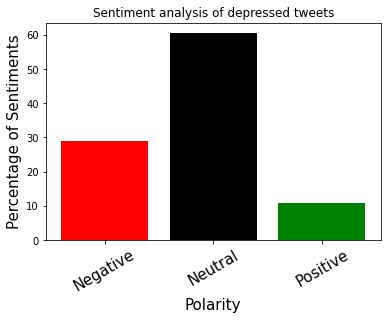

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[neg_percent,neu_percent,pos_percent],color=['red','black','green'])
plt.ylabel('Percentage of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.title('Sentiment analysis of depressed tweets')

## Sentiment Analysis of Tweets from Non-Depressed Individuals 

I create a wordcloud from the tweets from non-depressed individuals. Frequently used words include love, lol, thank, and good. I then do VADER sentiment analysis to compare it with the sentiment analysis from tweets from clinically depressed individuals. I prepare the data the same as I did above for depressed individuals. Nondepressed individuals had a very low (less than 5%) amount of negative tweets. 



<function matplotlib.pyplot.show>

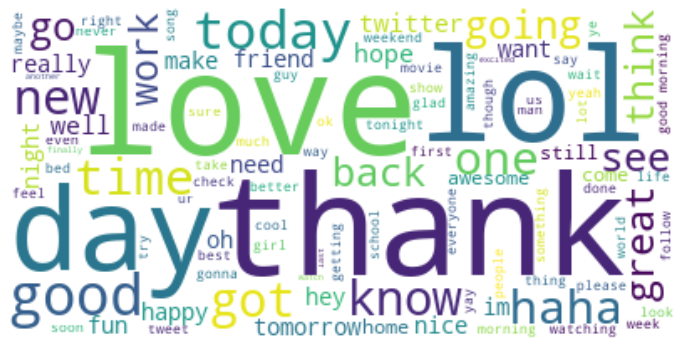

In [ ]:
notdepressed = df[df['label (depression result)'] == 0]
notdepressed_corpus = [item for sublist in notdepressed['tokenized'] for item in sublist]
filtered_notdepressed_corpus = [word for word in notdepressed_corpus if word not in stop_words]
filtered_notdepressed_corpus = ' '.join(filtered_notdepressed_corpus)
wordcloud = WordCloud(max_words=100, background_color="white").generate(filtered_notdepressed_corpus)

#display the generated image:
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

#wordcloud.to_file("img/notdepressed.png")

In [ ]:
#prepare the data for VADER analysis 

notdepressed = sentiment_prep(notdepressed, 'message to examine')

notdepressed.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct
0,106,"just had a real good moment. i missssssssss him so much,",0,just had a real good moment i missssssssss him so much,"[just, had, a, real, good, moment, i, misss, him, so, much]","just had a real good moment. i missssssssss him so much,"
1,217,is reading manga http://plurk.com/p/mzp1e,0,is reading manga,"[is, read, manga]",is reading manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0,,[],-
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0,Need to send em to my accountant tomorrow Oddly I wasn t even referring to my taxes Those are supporting evidence though,"[need, to, send, em, to, my, account, tomorrow, oddli, i, even, refer, to, my, tax, those, are, support, evid, though]","Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though."
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,ADD ME ON MYSPACE,"[add, me, on, myspac]",ADD ME ON MYSPACE!!!
5,624,so sleepy. good times tonight though,0,so sleepy good times tonight though,"[so, sleepi, good, time, tonight, though]",so sleepy. good times tonight though
6,701,"@SilkCharm re: #nbn as someone already said, does fiber to the home mean we will all at least be regular now",0,re nbn as someone already said does fiber to the home mean we will all at least be regular now,"[re, nbn, as, someon, alreadi, said, doe, fiber, to, the, home, mean, we, will, all, at, least, be, regular, now]","re: nbn as someone already said, does fiber to the home mean we will all at least be regular now"
7,808,23 or 24ï¿½C possible today. Nice,0,or C possible today Nice,"[or, ï, ½c, possibl, today, nice]",or ï¿½C possible today. Nice
8,1193,nite twitterville workout in the am -ciao,0,nite twitterville workout in the am ciao,"[nite, twittervil, workout, in, the, am, ciao]",nite twitterville workout in the am -ciao
9,1324,"@daNanner Night, darlin'! Sweet dreams to you",0,Night darlin Sweet dreams to you,"[night, darlin, sweet, dream, to, you]","Night, darlin'! Sweet dreams to you"


In [ ]:
notdepressed, ndneg_percent, ndneu_percent, ndpos_percent = sentimentscores(notdepressed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Sentiment analysis of not-depressed tweets')

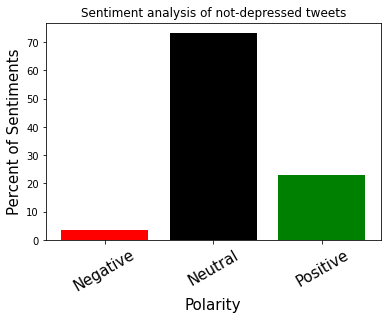

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[ndneg_percent,ndneu_percent,ndpos_percent],color=['red','black','green'])
plt.ylabel('Percent of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.title('Sentiment analysis of not-depressed tweets')


## Comparison of Sentiment Analysis

Clinically depressed indviduals posted more negative tweets, less positive tweets, and slightly less neutral tweets than non-depressed individuals. This means that more attention needs to be paid to negative tweets when trying to target depressed individuals. 

Text(0.5, 1.0, 'Sentiment Analysis of  Tweets')

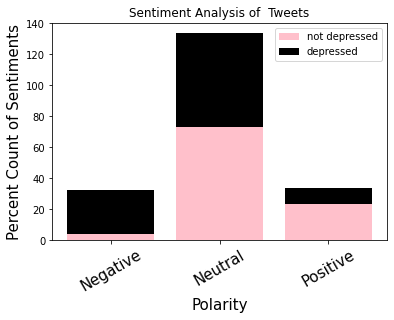

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']
index = np.arange(len(labels))
plt.bar(index,[ndneg_percent,ndneu_percent,ndpos_percent],color='pink')
plt.bar(index,[neg_percent,neu_percent,pos_percent],bottom = [ndneg_percent,ndneu_percent,ndpos_percent], 
        color='black')
plt.ylabel('Percent Count of Sentiments', fontsize=15)
plt.xlabel('Polarity', fontsize=15)
plt.xticks(index, labels, fontsize=15, rotation=30)
plt.legend(["not depressed", "depressed"])
plt.title('Sentiment Analysis of  Tweets')

## Modeling

The data was prepared for modeling by removing punctuation, special characters, URLs, and capitalization.  It was tokenized using the TweetTokenizer and stemmed. I split the data into train and test sets, map each word in the training set to a number, apply that mapping to the data (using 0 if it's an unknown word), and create a LSTM model. I calculate class weights to take into account the difference in amount of values between depressed and nondepressed tweets.  

In [ ]:
#train test split
X = df['tokenizedandstemmed']
Y = df['label (depression result)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

#train test split, before modeling, afer whatever steps I need to do; make the maps on the traning data
#make mapping based on training data; set some encoding to be like if I see a new word, how to handle it 


In [ ]:
def check_encoding(word, token_map):
  """ This function checks if encoding exists for a word. 

  Parameters:
  word (string): word to check
  token_map (set): mapping of words to their numerical representation

  Returns:
  int: encoding if it exists, 0 if it does not 

  """
  if word in token_map:
    return token_map.get(word)
  else: 
    return 0

In [ ]:
##convert words to indices.  I create a set, and add every word in the training data to it. 
word_set = set()
for sent in X_train:
  word_set.update(sent)

#I create a dictionary mapping each word to a number representing it 
#enumerate returns 2 variables, the count and the value of the item at that iteration 
token_map = {word: i+1 for i, word in enumerate(word_set)} #offset by 1 to allow for padding value
token_map['<#PAD>'] = 0

#create our sentences
X_train_indices = [[token_map[word] for word in sent] for sent in X_train ]

#use the encoding on the test data
X_test_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_test]

#dealing with sentences being dfferent lengths
X_train_indices = tf.keras.preprocessing.sequence.pad_sequences(X_train_indices, padding='post').tolist()
X_test_indices = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()

In [ ]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 256
hid_dim = 64

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(word_set)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(2), # 2 is the number of labels you want to pick from
                                    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2608896   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 2,691,205
Trainable params: 2,691,205
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.646022549326652, 1: 2.2120643431635387}

In [ ]:
#Compile the model 
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01)

X_train_ind_padded = np.array(X_train_indices)
X_test_ind_padded = np.array(X_test_indices)                          

history = model.fit(X_train_ind_padded, Y_train, class_weight=class_weights_dict, epochs = 10, batch_size=64, callbacks=[callback], verbose=1)

Epoch 1/10
129/129 [==============================] - 24s 155ms/step - loss: 0.4101 - accuracy: 0.8722
Epoch 2/10
129/129 [==============================] - 20s 153ms/step - loss: 0.0200 - accuracy: 0.9970
Epoch 3/10
129/129 [==============================] - 20s 152ms/step - loss: 0.0062 - accuracy: 0.9992
Epoch 4/10
129/129 [==============================] - 20s 155ms/step - loss: 0.0054 - accuracy: 0.9992


### Model Analysis 

The model has high accuracy, precision, recall, and f1 scores for test data.  There is not a large difference beween test and train data for accuracy. Since the model performs well on the given data, I decide to test it on brand nw daa from a different dataset.   

In [ ]:
score = model.evaluate(X_test_ind_padded, Y_test, verbose = 1)
score_train = model.evaluate(X_train_ind_padded, Y_train, verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model.predict(X_test_ind_padded)
#y_pred = np.argmax(y_pred1, axis=1)
y_pred = np.round(y_pred1).astype(int)

print((y_pred==1).sum())

print()
print('Precision Score')
print(precision_score(Y_test, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(Y_test, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(Y_test, y_pred, average='macro'))


258/258 [==============================] - 6s 20ms/step - loss: 0.0042 - accuracy: 0.9990

Evaluate on test data
Test loss: 0.039893988519907 / Test accuracy: 0.9936984777450562
Evaluate on train data
Train loss: 0.004202287644147873 / Train accuracy: 0.9990304112434387
438

Precision Score
0.9951661397962768

Recall Score
0.986327181703524

F1 Score
0.9906651356268533


## New Data

I now import data from Twitter to test the model against. I import the most recent 200 tweets each for #depression, #depressed, depression, and depressed. I also import 200 random tweets that do not mention depression. 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DepressionTweets/DepressionSentimentalAnalysis')
import config2

#config 2 has my passwords/keys 

In [ ]:
#get authorization from Twitter and create my API to gather data

auth_params = {
    'app_key': config2.api_key,
    'app_secret': config2.api_secret,
    'bearer_token': config2.bearer_token,
    'access_token': config2.access_token,
    'access_token_secret': config2.access_token_secret
}

auth = tweepy.OAuthHandler(auth_params['app_key'], auth_params['app_secret'])
auth.set_access_token(auth_params['access_token'], auth_params['access_token_secret'])

api = tweepy.API(auth, wait_on_rate_limit=True)


In [ ]:
#extract tweets 
hashtag_depressed_tweets = tweepy.Cursor(api.search, q="#depressed" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
depressed_tweets = tweepy.Cursor(api.search, q="depressed" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
hashtag_depression_tweets = tweepy.Cursor(api.search, q="#depression" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
depression_tweets = tweepy.Cursor(api.search, q="depression" + " -filter:retweets", lang='en', tweet_mode='extended').items(200)
random_tweets = tweepy.Cursor(api.search, q="-depressed" + '-depression' + '-#depressed' + '-#depression' + " -filter:retweets", lang='en', tweet_mode='extended').items(200)


In [ ]:
#each set gets made into it's own dataframe 
hdepressed = pd.DataFrame(data=[tweet.full_text for tweet in hashtag_depressed_tweets], columns=['message'])

In [ ]:
depressed = pd.DataFrame(data=[tweet.full_text for tweet in depressed_tweets], columns=['message'])

In [ ]:
hdepression = pd.DataFrame(data=[tweet.full_text for tweet in hashtag_depression_tweets], columns=['message'])

In [ ]:
depression = pd.DataFrame(data=[tweet.full_text for tweet in depression_tweets], columns=['message'])


In [ ]:
random = pd.DataFrame(data=[tweet.full_text for tweet in random_tweets], columns=['message'])

In [ ]:
#clean  the data for the model 

hdepressed_tokenized = clean_and_tokenize(hdepressed, 'message')
depressed_tokenized = clean_and_tokenize(depressed, 'message')
hdepression_tokenized = clean_and_tokenize(hdepression, 'message')
depression_tokenized = clean_and_tokenize(depression, 'message')
random_tokenized = clean_and_tokenize(random, 'message')

#add a column with the query term, and then combine the dataframes into 1

hdepressed_tokenized['query'] = 'hashtagdepressed'
depressed_tokenized['query'] = 'depressed'
hdepression_tokenized['query'] = 'hashtagdepression'
depression_tokenized['query'] = 'depression'
random_tokenized['query'] = 'random'


dataframes = [hdepressed_tokenized, depressed_tokenized, hdepression_tokenized,
              depression_tokenized, random_tokenized]
new_data = pd.concat(dataframes)

new_data.tail(10)

,message,tokenized,tokenizedandstemmed,query
190,@badmusib @olori_blessing Na only you understand o,"[na, only, you, understand, o]","[na, onli, you, understand, o]",random
191,LMAOOOOOOOOOOO WTF IS THIS https://t.co/I4eg5ouSuk,"[lmaooo, wtf, is, this]","[lmaooo, wtf, is, thi]",random
192,@longIivenini Oh nooo. I've had dreams like that too. Its the worst!,"[oh, nooo, ., i've, had, dreams, like, that, too, ., its, the, worst, !]","[oh, nooo, had, dream, like, that, too, it, the, worst]",random
193,Nu op KINK DNA: Bob Dylan - Subterranean Homesick Blues https://t.co/jUjb7XtMYQ,"[nu, op, kink, dna, :, bob, dylan, -, subterranean, homesick, blues]","[nu, op, kink, dna, bob, dylan, subterranean, homesick, blue]",random
194,So it's the same old shit,"[so, it's, the, same, old, shit]","[so, the, same, old, shit]",random
195,@PIB_Patna What do you have to say to this? Stop misleading people with your fake numbers and results. Have some shame. It's people and their lives we are talking about. Stop boot-licking. Stop it now. https://t.co/erVzN0yaC7,"[what, do, you, have, to, say, to, this, ?, stop, misleading, people, with, your, fake, numbers, and, results, ., have, some, shame, ., it's, people, and, their, lives, we, are, talking, about, ., stop, boot-licking, ., stop, it, now, .]","[what, do, you, have, to, say, to, thi, stop, mislead, peopl, with, your, fake, number, and, result, have, some, shame, peopl, and, their, live, we, are, talk, about, stop, stop, it, now]",random
196,@DincArman_ @eyatkafasi @imanastasios @sKOatXRPAyhq1kS @xruiztru @DrHerculePoirot I'm not Greek. But Constantinople was for christians something like Mekka for muslims. The fall of Constantinople was the end of the Middle Ages. But only for europeans. You are mentally in it to this day.,"[i'm, not, greek, ., but, constantinople, was, for, christians, something, like, mekka, for, muslims, ., the, fall, of, constantinople, was, the, end, of, the, middle, ages, ., but, only, for, europeans, ., you, are, mentally, in, it, to, this, day, .]","[not, greek, but, constantinopl, wa, for, christian, someth, like, mekka, for, muslim, the, fall, of, constantinopl, wa, the, end, of, the, middl, age, but, onli, for, european, you, are, mental, in, it, to, thi, day]",random
197,THIS IS SICKK https://t.co/SFsStU7Lvw,"[this, is, sickk]","[thi, is, sickk]",random
198,@thishalfworld st vincent v the other drug-addled dyke she tells you not to worry about,"[st, vincent, v, the, other, drug-addled, dyke, she, tells, you, not, to, worry, about]","[st, vincent, v, the, other, dyke, she, tell, you, not, to, worri, about]",random
199,@onlythighs_ SO PRETTY AWOOGAA,"[so, pretty, awoogaa]","[so, pretti, awoogaa]",random


In [ ]:
newdata_indices = [[check_encoding(word, token_map) for word in sent] for sent in new_data['tokenizedandstemmed']]
newdata_indices = tf.keras.preprocessing.sequence.pad_sequences(newdata_indices, padding = 'post').tolist()



In [ ]:
new = model.predict_classes(newdata_indices)
new_data.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(1000, 4)

In [ ]:
#check prediction against actual tweet for randomized set 
new_data['prediction'] = new

In [ ]:
new_data['prediction'].value_counts()

1    798
0    202
Name: prediction, dtype: int64

In [ ]:
randomsample = new_data.sample(n=50)
randomsample.head(20)

,message,tokenized,tokenizedandstemmed,query,prediction
193,Nu op KINK DNA: Bob Dylan - Subterranean Homesick Blues https://t.co/jUjb7XtMYQ,"[nu, op, kink, dna, :, bob, dylan, -, subterranean, homesick, blues]","[nu, op, kink, dna, bob, dylan, subterranean, homesick, blue]",random,0
59,"@hayden_schill shows visual hindsight bias for mammogram abnormalities in expert radiologists: they see abnormalities under noise that they couldn’t otherwise see, but only if they’ve been previously exposed to the image (several images previously) https://t.co/2315Ywf2nL https://t.co/bZUm3kgnlQ","[shows, visual, hindsight, bias, for, mammogram, abnormalities, in, expert, radiologists, :, they, see, abnormalities, under, noise, that, they, couldn, ’, t, otherwise, see, ,, but, only, if, they, ’, ve, been, previously, exposed, to, the, image, (, several, images, previously, )]","[show, visual, hindsight, bia, for, mammogram, abnorm, in, expert, radiologist, they, see, abnorm, under, nois, that, they, couldn, t, otherwis, see, but, onli, if, they, ve, been, previous, expos, to, the, imag, sever, imag, previous]",random,0
98,"@davido @blackgoldtwitt please my rent is due I’m in huge debt, I’m just a student please tell @racksterli to refund me my 112k everyday new problems keep adding up, please I’m really depressed at the moment","[please, my, rent, is, due, i, ’, m, in, huge, debt, ,, i, ’, m, just, a, student, please, tell, to, refund, me, my, k, everyday, new, problems, keep, adding, up, ,, please, i, ’, m, really, depressed, at, the, moment]","[pleas, my, rent, is, due, i, m, in, huge, debt, i, m, just, a, student, pleas, tell, to, refund, me, my, k, everyday, new, problem, keep, ad, up, pleas, i, m, realli, depress, at, the, moment]",depressed,1
153,"@x1_kayleigh_1x @RaelleLogan1 Check it out \nMay is #MentalHealthAwarenessMonth . Check out my book ""The Many Personalities of Me"" which is detailing my life living with mental health issues.\nhttps://t.co/XyqcJhcDWZ\n #mentalhealth #MentalHealthAwarenessMonth #depression","[check, it, out, may, is, mentalhealthawarenessmonth, ., check, out, my, book, "", the, many, personalities, of, me, "", which, is, detailing, my, life, living, with, mental, health, issues, ., mentalhealth, mentalhealthawarenessmonth, depression]","[check, it, out, may, is, mentalhealthawarenessmonth, check, out, my, book, the, mani, person, of, me, which, is, detail, my, life, live, with, mental, health, issu, mentalhealth, mentalhealthawarenessmonth, depress]",hashtagdepression,1
72,"also like, i genuinely struggle with getting out of bed in the mornings bc of my depression, morning shifts are so fucking difficult for me to be on time to. i’m trying my best here????","[also, like, ,, i, genuinely, struggle, with, getting, out, of, bed, in, the, mornings, bc, of, my, depression, ,, morning, shifts, are, so, fucking, difficult, for, me, to, be, on, time, to, ., i, ’, m, trying, my, best, here, ?, ?, ?]","[also, like, i, genuin, struggl, with, get, out, of, bed, in, the, morn, bc, of, my, depress, morn, shift, are, so, fuck, difficult, for, me, to, be, on, time, to, i, m, tri, my, best, here]",depression,1
171,this is crazyyyy,"[this, is, crazyyy]","[thi, is, crazyyi]",random,0
27,Things you should no longer be creating space for 💯 \n\n#motivation #Inspiration #meditation #Anxiety #depressed #depression #anxietyrelief https://t.co/GWrZkpXDDw,"[things, you, should, no, longer, be, creating, space, for, 💯, motivation, inspiration, meditation, anxiety, depressed, depression, anxietyrelief]","[thing, you, should, no, longer, be, creat, space, for, motiv, inspir, medit, anxieti, depress, depress, anxietyrelief]",hashtagdepressed,1
31,@GMB @richardgaisford And as far as “tell somebody “ if you’re depressed then be very careful who you tell. I also told family and they count handle it and blocked me! Sometimes family is too “close” and exactly how Harry said he was ashamed of how he handled it- family can panic and shut down :-(,"

### New Data Analysis 

I combine all the tweets into a new dataframe, prepare the data the same way I did the original data, and run the model on it for more testing. I do this in order to test the model more extensively, as the metric scores were very good on the given dataset.

I select a random amount of the new tweets to look more closely at, and look at the overall totals for those classified as depressed or not depressed.  The model classified the vast majority of data with the word 'depressed' or 'depression' in it as from a clinically depressed individual. It struggles to recognize informational or positive posts as well as exaggeration or informal use of the word depression.

## Model Refinement

Given that the model did not perform as well as I'd like on newly sourced data, I refine the model again. I create a new class that stands for "not enough information".  I do this by scrambling the order of words in the depressed tweets, to teach the model that the word 'depression' alone is not enough for a tweet to be classified as depressed. 

In [ ]:
def scramble(sentence):
  """ Rearranges the words in a string """
  split = sentence.split() #splits the string into a list of words
  shuffle(split)
  return ' '.join(split)

In [ ]:
#creates a list of a scrambled version of the depressed tweets. 

shuffled = []
for index, row in dep.iterrows():
 sentence = scramble(row['message to examine'])
 shuffled.append(sentence)


In [ ]:
dep.head()

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed,tokenizedwithpunct,Topic,topic_name,polarity
8000,800000,The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,1,The lack of this understanding is a small but significant part of what causes anxiety depression to both feel so incredibly lonely It s soooo easy to compare It s so easy to invalidate ourselves because of that,"[the, lack, of, thi, understand, is, a, small, but, signific, part, of, what, caus, anxieti, depress, to, both, feel, so, incred, lone, sooo, easi, to, compar, so, easi, to, invalid, ourselv, becaus, of, that]",The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,4,depression_experience,"{'neg': 0.238, 'neu': 0.555, 'pos': 0.207, 'compound': -0.1767}"
8001,800001,i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,1,i just told my parents about my depression and it s so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,"[i, just, told, my, parent, about, my, depress, and, so, hard, to, get, gen, x, peopl, to, understand, that, thi, is, not, someth, that, i, can, control, all, the, time, or, just, cure, with, a, walk, or, by, keep, my, mind, busi]",i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,4,depression_experience,"{'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compound': -0.6774}"
8002,800002,"depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",1,depression is something i don t speak about even going through it because it s also such a double edged sword i love every race even if white people had done so much i can t hate them all my grandma is legit white how tf can i hate i do dislike people though,"[depress, is, someth, i, speak, about, even, go, through, it, becaus, also, such, a, doubl, edg, sword, i, love, everi, race, even, if, white, peopl, had, done, so, much, i, hate, them, all, my, grandma, is, legit, white, how, tf, can, i, hate, i, do, dislik, peopl, though]","depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",4,depression_experience,"{'neg': 0.162, 'neu': 0.725, 'pos': 0.113, 'compound': -0.4756}"
8003,800003,Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0,1,Made myself a tortilla filled with pb j My depression is cured Olivia depression,"[made, myself, a, tortilla, fill, with, pb, j, my, depress, is, cure, olivia, depress]",Made myself a tortilla filled with pb&j. My depression is cured. Olivia: depression:,4,depression_experience,"{'neg': 0.402, 'neu': 0.598, 'pos': 0.0, 'compound': -0.8126}"
8004,800004,"@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>",1,I am gonna need depression meds soon these rainouts are spinning my equilibrium out Emoji Pouting face Mother Nature is being a mean B 

In [ ]:
#create a data frame with the scrambled sentences 
shuffleddata = pd.DataFrame(data=shuffled, columns=['message to examine'])
shuffleddata['label (depression result)'] = 2
shuffleddata.head()


,message to examine,label (depression result)
0,to lonely. anxiety what part depression The & easy It's both compare. ourselves to causes easy of of incredibly of but that. feel significant this so because It's lack to understanding so small invalidate soooo a is,2
1,is hard i so mind just told with all by my to this it's that about walk parents cure time just i busy x or people gen or get control can and not depression that to the a my understand my something keeping,2
2,"white hate tf race. also even sword. even i dislike so people is every it through grandma it's i speak can't do about edged i though. double because much can a if depression legit such them hate, is how love all. going had i done don't my i people white! something",2
3,myself filled Olivia:1 depression:0 pb&j. a is depression Made with tortilla My cured.,2
4,"my is Mother I out rainouts <Emoji: being soon, over a mean spinning symbols with am face> B-T-H Nature equilibrium mouth> these Face @WorldofOutlaws depression gonna are Pouting <Emoji: need meds",2


In [ ]:
#clean and tokenize the data, and randomly select 1000 tweets to add to the dataset to represent the new category. 
shuffleddata_tokenized = clean_and_tokenize(shuffleddata, 'message to examine')
randomsamplesd = shuffleddata_tokenized.sample(n=1000)


In [ ]:
dataframes = [df, randomsamplesd]
new_df = pd.concat(dataframes)
new_df.tail()

,Index,message to examine,label (depression result),tokenized,tokenizedandstemmed
487,NaN,"research Hay linked depression @stylistmagazine â¦ @StylistMagazine anxiety increased finds risk, via fever to and https://www.stylist.co.uk/life/hay-fever-risk-allergies-mental-health-anxiety-depression/203144Â",2,"[research, hay, linked, depression, â, , ¦, anxiety, increased, finds, risk, ,, via, fever, to, and]","[research, hay, link, depress, â, anxieti, increas, find, risk, via, fever, to, and]"
1726,NaN,this Reading struggling good depression. with anxiety me. Japanese Maybe â¦ or for helped friends https://twitter.com/sheepchase/status/988951764106821632Â,2,"[this, reading, struggling, good, depression, ., with, anxiety, me, ., japanese, maybe, â, , ¦, or, for, helped, friends]","[thi, read, struggl, good, depress, with, anxieti, me, japanes, mayb, â, or, for, help, friend]"
2152,NaN,Depression in Jedi https://coub.com/v/vfyxtÂ Last @coub The,2,"[depression, in, jedi, last, the]","[depress, in, jedi, last, the]"
438,NaN,"https://cmun.it/lu4yifÂ https://commun.it/grow-your-followers/?tc=n&aid=content_15Â #health Suicide Spray Shows Rocket>Grow with <Emoji: Nasal followers Promise Against Ketamine - â¦ Depression, your",2,"[health, suicide, spray, shows, rocket, >, grow, with, <, emoji, :, nasal, followers, promise, against, ketamine, -, â, , ¦, depression, ,, your]","[health, suicid, spray, show, rocket, grow, with, emoji, nasal, follow, promis, against, ketamin, â, depress, your]"
748,NaN,leads which the i to asian have and also a say about lot to to depression/anxiety immigrants pressure succeed,2,"[leads, which, the, i, to, asian, have, and, also, a, say, about, lot, to, to, depression, /, anxiety, immigrants, pressure, succeed]","[lead, which, the, i, to, asian, have, and, also, a, say, about, lot, to, to, depress, anxieti, immigr, pressur, succeed]"


#### Models

I create 3 more versions of the model.  I explore early stopping, adding dropout layers, class weights, and changing various paramaters in order to avoid overfitting and better train the model. I decide on Model 3 as the final model due to it's high recall and f1 score for depressed data, even though it does not identify any tweets as "not enough information".  I want the model to catch as many depressed cases as possible. Even though this model does not classify any tweets as "not enough information", it overfits less than the orginal model does. I then apply this model and another model to the data sourced from twitter.  It performs better than the first model, but does continue to struggle to correctly classify informational, positive, and exagerrated tweets. 

In [ ]:
#train test split
X = new_df['tokenizedandstemmed']
Y = new_df['label (depression result)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

In [ ]:
##convert words to indices.  I create a set, and add every word in the training data to it. 
word_set2 = set()
for sent in X_train:
  word_set2.update(sent)

#I create a dictionary mapping each word to a number representing it 
#enumerate returns 2 variables, the count and the value of the item at that iteration 
token_map2 = {word: i+1 for i, word in enumerate(word_set2)} #offset by 1 to allow for padding value
token_map2['<#PAD>'] = 0

#create our sentences
X_train_indices = [[token_map2[word] for word in sent] for sent in X_train ]

#use the encoding on the test data
X_test_indices = [[check_encoding(word, token_map2) for word in sent] for sent in X_test]

#dealing with sentences being dfferent lengths
X_train_indices = tf.keras.preprocessing.sequence.pad_sequences(X_train_indices, padding='post').tolist()
X_test_indices = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()

In [ ]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 128
hid_dim = 8

model2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(word_set2)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu),
                                    tf.keras.layers.Dense(3, use_bias=False), # is the number of labels you want to pick from
                                    tf.keras.layers.Softmax()
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1316992   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 4384      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
softmax (Softmax)            (None, 3)                 0         
Total params: 1,321,412
Trainable params: 1,321,412
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile the model 
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

X_train_ind_padded = np.array(X_train_indices)
X_test_ind_padded = np.array(X_test_indices)                          

history = model2.fit(X_train_ind_padded, Y_train, epochs = 15, batch_size=64, callbacks=[callback], verbose=1)

Epoch 1/15
142/142 [==============================] - 13s 62ms/step - loss: 0.9439 - accuracy: 0.7279
Epoch 2/15
142/142 [==============================] - 9s 61ms/step - loss: 0.3939 - accuracy: 0.8676
Epoch 3/15
142/142 [==============================] - 9s 61ms/step - loss: 0.2057 - accuracy: 0.9008
Epoch 4/15
142/142 [==============================] - 9s 61ms/step - loss: 0.1701 - accuracy: 0.9109
Epoch 5/15
142/142 [==============================] - 9s 62ms/step - loss: 0.1387 - accuracy: 0.9412
Epoch 6/15
142/142 [==============================] - 9s 62ms/step - loss: 0.1134 - accuracy: 0.9619
Epoch 7/15
142/142 [==============================] - 9s 61ms/step - loss: 0.0928 - accuracy: 0.9688
Epoch 8/15
142/142 [==============================] - 9s 61ms/step - loss: 0.0714 - accuracy: 0.9778
Epoch 9/15
142/142 [==============================] - 9s 61ms/step - loss: 0.0592 - accuracy: 0.9809
Epoch 10/15
142/142 [==============================] - 9s 62ms/step - loss: 0.0508 - accur

In [ ]:
score = model2.evaluate(X_test_ind_padded, Y_test, verbose = 1)
score_train = model2.evaluate(X_train_ind_padded, Y_train, verbose = 1)
target_names = ['class 0', 'class 1', 'class 2']

#print(model(np.array(df['indices'].to_list())).numpy().tolist())

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

from sklearn.metrics import classification_report

y_pred1 = model2.predict(X_test_ind_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)


print(classification_report(Y_test, y_pred, target_names=target_names))


283/283 [==============================] - 4s 10ms/step - loss: 0.0206 - accuracy: 0.9944
Evaluate on test data
Test loss: 0.5486075282096863 / Test accuracy: 0.8696420788764954
Evaluate on train data
Train loss: 0.020631149411201477 / Train accuracy: 0.9943652749061584
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1595
     class 1       0.68      0.71      0.70       468
     class 2       0.29      0.26      0.27       200

    accuracy                           0.87      2263
   macro avg       0.66      0.66      0.65      2263
weighted avg       0.87      0.87      0.87      2263



In [ ]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 128
hid_dim = 8

model3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(word_set2)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu),
                                    tf.keras.layers.Dropout(0.8), 
                                    tf.keras.layers.Dense(3, use_bias=False), # is the number of labels you want to pick from
                                    #tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Softmax()
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1316992   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 4384      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 9         
_________________________________________________________________
softmax_1 (Softmax)          (None, 3)                 0         
Total params: 1,321,412
Trainable params: 1,321,412
Non-trainable params: 0
____________________________________________

In [ ]:
#Compile the model 
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

X_train_ind_padded = np.array(X_train_indices)
X_test_ind_padded = np.array(X_test_indices)                          

history = model3.fit(X_train_ind_padded, Y_train, epochs = 50, batch_size=64, shuffle = True, 
                     callbacks=[callback],  verbose=1)

Epoch 1/50
142/142 [==============================] - 13s 61ms/step - loss: 1.0410 - accuracy: 0.6423
Epoch 2/50
142/142 [==============================] - 9s 63ms/step - loss: 0.8398 - accuracy: 0.6939
Epoch 3/50
142/142 [==============================] - 9s 61ms/step - loss: 0.7992 - accuracy: 0.7027
Epoch 4/50
142/142 [==============================] - 9s 62ms/step - loss: 0.7682 - accuracy: 0.7073
Epoch 5/50
142/142 [==============================] - 9s 62ms/step - loss: 0.7084 - accuracy: 0.7735
Epoch 6/50
142/142 [==============================] - 9s 61ms/step - loss: 0.6891 - accuracy: 0.7912
Epoch 7/50
142/142 [==============================] - 9s 62ms/step - loss: 0.6827 - accuracy: 0.7840
Epoch 8/50
142/142 [==============================] - 9s 62ms/step - loss: 0.6631 - accuracy: 0.7914
Epoch 9/50
142/142 [==============================] - 9s 63ms/step - loss: 0.6546 - accuracy: 0.7981
Epoch 10/50
142/142 [==============================] - 9s 61ms/step - loss: 0.6508 - accur

In [ ]:
score = model3.evaluate(X_test_ind_padded, Y_test, verbose = 1)
score_train = model3.evaluate(X_train_ind_padded, Y_train, verbose = 1)
target_names = ['class 0', 'class 1', 'class 2']

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


y_pred1 = model3.predict(X_test_ind_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)


print(classification_report(Y_test, y_pred, target_names=target_names))


166/283 [================>.............] - ETA: 1s - loss: 0.1657 - accuracy: 0.9701

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
class_weights_dict

In [ ]:



dim = 128
hid_dim = 8

model4 = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(word_set2)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.leaky_relu),
                                    tf.keras.layers.Dropout(0.5), 
                                    tf.keras.layers.Dense(3, use_bias=False), # is the number of labels you want to pick from
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Softmax()
])
model4.summary()

In [ ]:
#Compile the model 
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

X_train_ind_padded = np.array(X_train_indices)
X_test_ind_padded = np.array(X_test_indices)                          

history = model4.fit(X_train_ind_padded, Y_train, class_weight=class_weights_dict, epochs = 50, batch_size=64, shuffle = True, 
                     callbacks=[callback],  verbose=1)

Epoch 1/50
142/142 [==============================] - 13s 62ms/step - loss: 1.0861 - accuracy: 0.5204
Epoch 2/50
142/142 [==============================] - 8s 59ms/step - loss: 1.0475 - accuracy: 0.5976
Epoch 3/50
142/142 [==============================] - 8s 60ms/step - loss: 0.9595 - accuracy: 0.6469
Epoch 4/50
142/142 [==============================] - 8s 60ms/step - loss: 0.8943 - accuracy: 0.7303
Epoch 5/50
142/142 [==============================] - 8s 59ms/step - loss: 0.8226 - accuracy: 0.7545
Epoch 6/50
142/142 [==============================] - 8s 59ms/step - loss: 0.7792 - accuracy: 0.7733
Epoch 7/50
142/142 [==============================] - 8s 59ms/step - loss: 0.7589 - accuracy: 0.7670
Epoch 8/50
142/142 [==============================] - 8s 59ms/step - loss: 0.7227 - accuracy: 0.7710
Epoch 9/50
142/142 [==============================] - 8s 59ms/step - loss: 0.7107 - accuracy: 0.7754
Epoch 10/50
142/142 [==============================] - 9s 60ms/step - loss: 0.7253 - accur

In [ ]:
score = model4.evaluate(X_test_ind_padded, Y_test, verbose = 1)
score_train = model4.evaluate(X_train_ind_padded, Y_train, verbose = 1)
target_names = ['class 0', 'class 1', 'class 2']

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


y_pred1 = model4.predict(X_test_ind_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)

print(classification_report(Y_test, y_pred, target_names=target_names))

283/283 [==============================] - 4s 9ms/step - loss: 0.1006 - accuracy: 0.9912
Evaluate on test data
Test loss: 0.35827624797821045 / Test accuracy: 0.8714096546173096
Evaluate on train data
Train loss: 0.1006399393081665 / Train accuracy: 0.9911612272262573
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1595
     class 1       0.71      0.66      0.69       468
     class 2       0.36      0.43      0.40       200

    accuracy                           0.87      2263
   macro avg       0.69      0.69      0.69      2263
weighted avg       0.88      0.87      0.87      2263



### Twitter Data

I apply 2 models to the data sourced from twitter.  It performs better than the first model, but does continue to struggle to correctly classify informational, positive, and exagerrated tweets. Model 3 (final model) continues to classify almost all tweets featuring the word 'depression' as depressed. Model 4 overcompensates in the other direction, classifying too many depressed tweets as "not enough information." 

In [ ]:
newdata_indices = [[check_encoding(word, token_map2) for word in sent] for sent in new_data['tokenizedandstemmed']]
newdata_indices = tf.keras.preprocessing.sequence.pad_sequences(newdata_indices, padding = 'post').tolist()


In [ ]:
new = model3.predict_classes(newdata_indices)

new_data['prediction'] = new

new_data['prediction'].value_counts()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1    695
0    199
2    106
Name: prediction, dtype: int64

In [ ]:
new2 = model4.predict_classes(newdata_indices)

new_data['prediction2'] = new2

new_data['prediction2'].value_counts()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1    579
2    219
0    202
Name: prediction2, dtype: int64

In [ ]:
new_data[new_data['prediction2']==2]

,message,tokenized,tokenizedandstemmed,query,prediction,prediction2
1,"@PebblesResists Its Natural when something so traumatic happens to us to feel #Anxious &amp; #Depressed; People disappoint us, &amp; they're not there for us like we'd like them to be. But.. #KeepGoing #YouAreAmazing &amp; #YouWillDoAmazingThings ~ #IPromiseYou https://t.co/edYFpJwiWO","[its, natural, when, something, so, traumatic, happens, to, us, to, feel, anxious, &, depressed, ;, people, disappoint, us, ,, &, they're, not, there, for, us, like, we'd, like, them, to, be, ., but, .., keepgoing, youareamazing, &, youwilldoamazingthings, ~, ipromiseyou]","[it, natur, when, someth, so, traumat, happen, to, us, to, feel, anxiou, depress, peopl, disappoint, us, not, there, for, us, like, like, them, to, be, but, keepgo, youareamaz, youwilldoamazingth, ipromisey]",hashtagdepressed,2,2
4,Maybe your the perfect date cause you know how to set the mood\n.\n.\n.\nPoem: Hey Depression 3\n.\n.\n.\n#poet #poetry #poem #poetrylove #poetryisart #wordsoftheday #writer #poetryisnotdead #writing #kexum #depressed #heydepression #piecesofkblog\n\nhttps://t.co/A1HBZQ7I6I,"[maybe, your, the, perfect, date, cause, you, know, how, to, set, the, mood, . . ., poem, :, hey, depression, . . ., poet, poetry, poem, poetrylove, poetryisart, wordsoftheday, writer, poetryisnotdead, writing, kexum, depressed, heydepression, piecesofkblog]","[mayb, your, the, perfect, date, caus, you, know, how, to, set, the, mood, poem, hey, depress, poet, poetri, poem, poetrylov, poetryisart, wordsoftheday, writer, poetryisnotdead, write, kexum, depress, heydepress, piecesofkblog]",hashtagdepressed,1,2
5,"In 2016, broke and in debt due to a failed business, I tried to commit #suicide \n\nWhy? I was clinically #depressed with serious #anxiety due to the shame of failure. https://t.co/NpsYMrjCXo","[in, ,, broke, and, in, debt, due, to, a, failed, business, ,, i, tried, to, commit, suicide, why, ?, i, was, clinically, depressed, with, serious, anxiety, due, to, the, shame, of, failure, .]","[in, broke, and, in, debt, due, to, a, fail, busi, i, tri, to, commit, suicid, whi, i, wa, clinic, depress, with, seriou, anxieti, due, to, the, shame, of, failur]",hashtagdepressed,2,2
16,FREE Taster Experience...\nhttps://t.co/33hTTqH9uI\nMid-Morn Weight-Loss Top-Tip:\nBeing Active Burns MORE Calories - Than Dieting. \n#obese #overweight #fat #depressed #unhealthy #confused #eat #control #discipline #shape #figure #slim #toned #obesity #weightloss #burnfat #lean https://t.co/j1lJYBxFXH,"[free, taster, experience, ..., mid-morn, weight-loss, top-tip, :, being, active, burns, more, calories, -, than, dieting, ., obese, overweight, fat, depressed, unhealthy, confused, eat, control, discipline, shape, figure, slim, toned, obesity, weightloss, burnfat, lean]","[free, taster, experi, be, activ, burn, more, calori, than, diet, obes, overweight, fat, depress, unhealthi, confus, eat, control, disciplin, shape, figur, slim, tone, obes, weightloss, burnfat, lean]",hashtagdepressed,1,2
19,I am #depressed could use a friend but feel like I have none.,"[i, am, depressed, could, use, a, friend, but, feel, like, i, have, none, .]","[i, am, depress, could, use, a, friend, but, feel, like, i, have, none]",hashtagdepressed,1,2
...,...,...,...,...,...,...
198,"if you do not suffer from anxiety or depression, i would never expect you to understand where i come from.","[if, you, do, not, suffer, from, anxiety, or, depression, ,, i, would, never, expect, you, to, understand, where, i, come, from, .]","[if, you, do, not, suffer, from, anxieti, or, depress, i, would, never, expect, you, to, understand, where, i, come, from]",depression,2,2
199,Never be afraid to seek help!\n#STOPBULLYING #pilottv #raynaraytv #stopbullying #antibullying #bullyingawareness #love #suicideprevention #cyberbullying #nobullying #mentalhealth #bullyingprevention #stopbullyingnow #endbullying #bekind #bully #depression #bullyinghurts #teens https://t.co/X81OZ3rDgl,"[

In [ ]:
randomsample = new_data.sample(n=50)
randomsample.head(20)

,message,tokenized,tokenizedandstemmed,query,prediction,prediction2
10,depression cause you need your roots done is a real thing,"[depression, cause, you, need, your, roots, done, is, a, real, thing]","[depress, caus, you, need, your, root, done, is, a, real, thing]",depression,2,2
150,"New research commissioned for #MentalHealthAwarenessWeek (10-16 May) has found that almost three in five (58%) of #tradespeople have experienced some form of #mentalhealthproblems such as #stress, #anxiety or #depression. https://t.co/89vjgC95dS @UKConstructionm https://t.co/MkS3WJ4lK2","[new, research, commissioned, for, mentalhealthawarenessweek, (, -, may, ), has, found, that, almost, three, in, five, (, %, ), of, tradespeople, have, experienced, some, form, of, mentalhealthproblems, such, as, stress, ,, anxiety, or, depression, .]","[new, research, commiss, for, mentalhealthawarenessweek, may, ha, found, that, almost, three, in, five, of, tradespeopl, have, experienc, some, form, of, mentalhealthproblem, such, as, stress, anxieti, or, depress]",hashtagdepression,1,1
95,"@rishibagree How many people got real help from Rajdeep or is he even help his colleagues, neighbours. \nDid he even give any #hopes to people who infected or #depressed because of #illness, #mentalTrauma, #FinancialLosses","[how, many, people, got, real, help, from, rajdeep, or, is, he, even, help, his, colleagues, ,, neighbours, ., did, he, even, give, any, hopes, to, people, who, infected, or, depressed, because, of, illness, ,, mentaltrauma, ,, financiallosses]","[how, mani, peopl, got, real, help, from, rajdeep, or, is, he, even, help, hi, colleagu, neighbour, did, he, even, give, ani, hope, to, peopl, who, infect, or, depress, becaus, of, ill, mentaltrauma, financialloss]",hashtagdepressed,1,1
155,This is absolutely amazing and welcome for those of us who have mental health issues. #Anxiety #Depression #PTSD @PHLAirport https://t.co/xYelhFBxbD,"[this, is, absolutely, amazing, and, welcome, for, those, of, us, who, have, mental, health, issues, ., anxiety, depression, ptsd]","[thi, is, absolut, amaz, and, welcom, for, those, of, us, who, have, mental, health, issu, anxieti, depress, ptsd]",hashtagdepression,1,1
154,"@RyJumbalot @RaelleLogan1 Check it out \nMay is #MentalHealthAwarenessMonth . Check out my book ""The Many Personalities of Me"" which is detailing my life living with mental health issues.\nhttps://t.co/XyqcJhcDWZ\n #mentalhealth #MentalHealthAwarenessMonth #depression","[check, it, out, may, is, mentalhealthawarenessmonth, ., check, out, my, book, "", the, many, personalities, of, me, "", which, is, detailing, my, life, living, with, mental, health, issues, ., mentalhealth, mentalhealthawarenessmonth, depression]","[check, it, out, may, is, mentalhealthawarenessmonth, check, out, my, book, the, mani, person, of, me, which, is, detail, my, life, live, with, mental, health, issu, mentalhealth, mentalhealthawarenessmonth, depress]",hashtagdepression,1,1
62,Let me start off with one of my favorites!!!! \n\n#poet #poem #depression #poetry #WritingCommunity #Writer https://t.co/d8U85djkAd,"[let, me, start, off, with, one, of, my, favorites, !, !, !, poet, poem, depression, poetry, writingcommunity, writer]","[let, me, start, off, with, one, of, my, favorit, poet, poem, depress, poetri, writingcommun, writer]",hashtagdepression,1,1
145,Exactly that! It's okay to take care of yourself &amp; take some time out for yourself.\n\nHave a great weekend everyone.😀\n\n#psychotherapy #wellbeing #health #therapy #experienced #mindfulness #anxiety #depression #yournotalone #Happiness #wellness #mentalhealthmatters #FridayFeeling https://t.co/s5tJTVIci4,"[exactly, that, !, it's, okay, to, take, care, of, yourself, &, take, some, time, out, for, yourself, ., have, a, great, weekend, everyone, ., 😀, psychotherapy, wellbeing, health, therapy, experienced, mindfulness, anxiety, depression, yournotalone, happiness, wellness, mentalhealthmatters, fridayfeeling]","[exactli, that, ok

# Conclusions

Analyzing social media data could help identify individuals who are unable or not willing to talk to professionals about their emotions. Many individuals share their emotions on social media regarding depression.  

## Business Recommendations

*   Respond to users who say they're feeling depressed, worthless, or hurting with empathetic responses, informative posts, and advertisements about the benefits of counseling or this agency. 
*   Increase social media presence.  Make informational or positive posts about depression and counseling.  
*   Use how individuals talk about their depression experiences on social media to inform how you talk to people about depression. 






### Future Work: 

- Create a model that codes tweets for depression criteria
- Create a model that does better at seeing the difference between informational tweets about depression and depressed tweets - perhaps by classifying tweets 3 ways, depressed, not depressed, information about depression. 
- Possibly creating a bot that could reach out to individuals seen as at-risk of depression 
- A model that flags suicidal comments or classifies risk 